# 予備実験(訂正版) 2値分類

## 必要なモジュールのインポート

In [1]:
%load_ext tensorboard
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import TensorBoard

## データセットの用意

In [2]:
full_dataset_path = "./full_set.txt"

In [3]:
full_dataset = []
f = open(full_dataset_path, "r", encoding='utf-8')
for row in f:
    full_dataset.append(row.strip())
f.close()

In [4]:
full_utter_user = []
full_utter = []
full_utter_label = []

In [5]:
for j in full_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            full_utter_user.append(v)
        elif i==1:
            full_utter.append(v)
        else:
            full_utter_label.append(v)
            
print("finish")

finish


### ラベルデータ数値化

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
non_remove_labels = ["sd", "sv"]

In [11]:
label = {}
for i,v in enumerate(non_remove_labels):
    label[v] = to_categorical(i, num_classes=len(non_remove_labels))

## Tensorflow型のデータ変換

In [15]:
full_utter_labels = []
full_utters = []
for i,v in enumerate(full_utter_label):
    if v in non_remove_labels:
        full_utter_labels.append(label[v])
        full_utters.append(full_utter[i])

In [17]:
full_data = tf.data.Dataset.from_tensor_slices((full_utters, full_utter_labels))

## トークナイザー

In [18]:
## ボキャブラリーリスト
vocabulary_set = set()
## トークナイザー
tokenizer = tfds.deprecated.text.Tokenizer()

#full_data_list = [train_data, val_data]

## 分かち書き
for i,_ in full_data:
    some_tokens = tokenizer.tokenize(i.numpy())
    vocabulary_set.update(some_tokens)
    
## ボキャブラリーリスト作成
vocab_size = len(vocabulary_set)

## encode生成

In [19]:
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set)

In [20]:
def encode(token, label):
    token = encoder.encode(token.numpy())
    return token, label

@tf.function
def tf_encoder(utter, label):
    encoded_text, label = tf.py_function(encode,[utter, label],[tf.int64, tf.float32])
    encoded_text.set_shape([None])
    return encoded_text, label

## metrics

In [21]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## データ設計

In [22]:
max_len = 40

all_full_data_encode = full_data.map(tf_encoder)
test_size = 10000
val_size = 10000
all_train = all_full_data_encode.skip(test_size)
all_test = all_full_data_encode.take(test_size)
all_val = all_train.take(val_size)
all_trains = all_train.skip(val_size)

In [23]:
utter_train_data = all_trains.padded_batch(64, padded_shapes=([None], [2]), drop_remainder=True)
utter_test_data = all_test.padded_batch(64, padded_shapes=([None], [2]), drop_remainder=True)
utter_val_data = all_val.padded_batch(64, padded_shapes=([None], [2]), drop_remainder=True)

## RNNモデル設計

In [78]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(22302, 64),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          1427328   
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 1,456,578
Trainable params: 1,456,578
Non-trainable params: 0
_________________________________________________________________


### RNNモデルコンパイル

In [30]:
rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=METRICS)

### RNNモデル実行

In [33]:
rnn_history = rnn_model.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
1274/1274 [==============================] - 36s 28ms/step - loss: 0.1425 - tp: 75798.0000 - fp: 5738.0000 - tn: 75798.0000 - fn: 5738.0000 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9868 - val_loss: 1.3498 - val_tp: 1504.0000 - val_fp: 416.0000 - val_tn: 1504.0000 - val_fn: 416.0000 - val_accuracy: 0.7833 - val_precision: 0.7833 - val_recall: 0.7833 - val_auc: 0.8236
Epoch 2/14
1274/1274 [==============================] - 36s 28ms/step - loss: 0.1371 - tp: 76055.0000 - fp: 5481.0000 - tn: 76055.0000 - fn: 5481.0000 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9878 - val_loss: 1.4658 - val_tp: 1491.0000 - val_fp: 429.0000 - val_tn: 1491.0000 - val_fn: 429.0000 - val_accuracy: 0.7766 - val_precision: 0.7766 - val_recall: 0.7766 - val_auc: 0.8113
Epoch 3/14
1274/1274 [==============================] - 36s 28ms/step - loss: 0.1321 - tp: 76212.0000 - fp: 5324.0000 - tn: 76212.0000 - fn: 5324.0000 - accuracy: 0.9347 - precision: 0.9347 - 

### RNNモデル評価

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [35]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(rnn_model.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
        y_test.append(non_remove_labels[i])

    for i in pred:
        y_pred.append(non_remove_labels[i])

print(len(y_test))

9984


#### accuracy & macro平均F値

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          sd       0.88      0.77      0.82      7128
          sv       0.56      0.75      0.64      2856

    accuracy                           0.76      9984
   macro avg       0.72      0.76      0.73      9984
weighted avg       0.79      0.76      0.77      9984



#### 混同行列

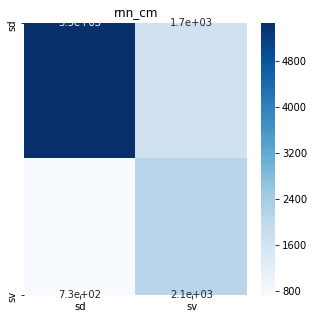

In [60]:
rnn_cm = confusion_matrix(y_test, y_pred, non_remove_labels)
df = pd.DataFrame(rnn_cm, index=non_remove_labels, columns=non_remove_labels)
plt.figure(figsize=(5, 5))
plt.title("rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("graph/rnn_cm2.png")

In [75]:
print(rnn_cm)

[[5463 1665]
 [ 727 2129]]


## RNNモデル(双方向)

In [77]:
Bidirectional_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(22302, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          1427328   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 1,485,634
Trainable params: 1,485,634
Non-trainable params: 0
_________________________________________________________________


### RNNモデル(双方向)コンパイル

In [79]:
Bidirectional_rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=METRICS)

### RNNモデル(双方向)実行

In [80]:
Bidirectional_rnn_history = Bidirectional_rnn_model.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
1274/1274 [==============================] - 38s 30ms/step - loss: 0.4240 - tp: 66657.0000 - fp: 16799.0000 - tn: 66657.0000 - fn: 16799.0000 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8834 - val_loss: 0.3527 - val_tp: 1608.0000 - val_fp: 312.0000 - val_tn: 1608.0000 - val_fn: 312.0000 - val_accuracy: 0.8375 - val_precision: 0.8375 - val_recall: 0.8375 - val_auc: 0.9223
Epoch 2/14
1274/1274 [==============================] - 37s 29ms/step - loss: 0.3553 - tp: 68164.0000 - fp: 13372.0000 - tn: 68164.0000 - fn: 13372.0000 - accuracy: 0.8360 - precision: 0.8360 - recall: 0.8360 - auc: 0.9210 - val_loss: 0.3516 - val_tp: 1607.0000 - val_fp: 313.0000 - val_tn: 1607.0000 - val_fn: 313.0000 - val_accuracy: 0.8370 - val_precision: 0.8370 - val_recall: 0.8370 - val_auc: 0.9229
Epoch 3/14
1274/1274 [==============================] - 37s 29ms/step - loss: 0.3208 - tp: 69600.0000 - fp: 11936.0000 - tn: 69600.0000 - fn: 11936.0000 - accuracy: 0.8536 - precision: 0.8

In [81]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(Bidirectional_rnn_model.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
        y_test.append(non_remove_labels[i])

    for i in pred:
        y_pred.append(non_remove_labels[i])

print(len(y_test))

9984


#### accuracy & macro平均F値

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          sd       0.88      0.79      0.84      7128
          sv       0.59      0.73      0.65      2856

    accuracy                           0.78      9984
   macro avg       0.73      0.76      0.74      9984
weighted avg       0.80      0.78      0.78      9984



#### 混同行列

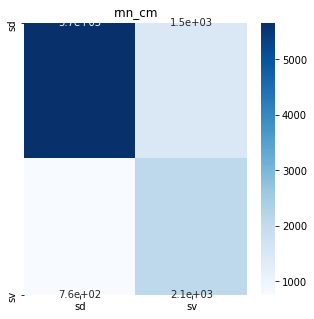

In [85]:
Bidirectional_rnn_cm = confusion_matrix(y_test, y_pred, non_remove_labels)
df = pd.DataFrame(Bidirectional_rnn_cm, index=non_remove_labels, columns=non_remove_labels)
plt.figure(figsize=(5, 5))
plt.title("rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("graph/Bidirectional_rnn_cm.png")

In [86]:
print(Bidirectional_rnn_cm)

[[5658 1470]
 [ 758 2098]]


## Self-Attentionモデル設計

In [61]:
from keras_self_attention import SeqSelfAttention

In [62]:
BATCH_SIZE = 64

In [68]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, BATCH_SIZE)(inp) # (?,128,32)
gru_output = tf.keras.layers.GRU(BATCH_SIZE,return_sequences=True)(emb_output)
att_layer_output = SeqSelfAttention(name='attention')(gru_output)  # embbedingレイヤーの後にselfattentionを配置
out = tf.keras.layers.GlobalMaxPooling1D()(att_layer_output) # outputのshapeの次元数を落とす(3次元->2次元)
output = tf.keras.layers.Dense(2, activation='softmax')(out)  # shape=(?, 41)
self_attention_model_max = tf.keras.Model(inp, output)
self_attention_model_max.summary()
self_attention_model_max.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (64, None, 64)            1427328   
_________________________________________________________________
gru_5 (GRU)                  (64, None, 64)            24960     
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 64)            4161      
_________________________________________________________________
global_max_pooling1d_3 (Glob (64, 64)                  0         
_________________________________________________________________
dense_7 (Dense)              (64, 2)                   130       
Total params: 1,456,579
Trainable params: 1,456,579
Non-trainable params: 0
____________________________________________

### self-attentionモデル実行

In [69]:
self_attention_history_max = self_attention_model_max.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
1274/1274 [==============================] - 47s 37ms/step - loss: 0.4334 - tp: 64786.0000 - fp: 16750.0000 - tn: 64786.0000 - fn: 16750.0000 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.8797 - val_loss: 0.3462 - val_tp: 1617.0000 - val_fp: 303.0000 - val_tn: 1617.0000 - val_fn: 303.0000 - val_accuracy: 0.8422 - val_precision: 0.8422 - val_recall: 0.8422 - val_auc: 0.9253
Epoch 2/14
1274/1274 [==============================] - 47s 37ms/step - loss: 0.3631 - tp: 67792.0000 - fp: 13744.0000 - tn: 67792.0000 - fn: 13744.0000 - accuracy: 0.8314 - precision: 0.8314 - recall: 0.8314 - auc: 0.9174 - val_loss: 0.3527 - val_tp: 1617.0000 - val_fp: 303.0000 - val_tn: 1617.0000 - val_fn: 303.0000 - val_accuracy: 0.8422 - val_precision: 0.8422 - val_recall: 0.8422 - val_auc: 0.9226
Epoch 3/14
1274/1274 [==============================] - 47s 37ms/step - loss: 0.3300 - tp: 69304.0000 - fp: 12232.0000 - tn: 69304.0000 - fn: 12232.0000 - accuracy: 0.8500 - precision: 0.8

### モデルの評価

In [70]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_model_max.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
        y_test.append(non_remove_labels[i])
    for i in pred:
        y_pred.append(non_remove_labels[i])

print(len(y_test))

9984


#### accuracy & macro平均F値

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          sd       0.88      0.78      0.83      7128
          sv       0.57      0.75      0.65      2856

    accuracy                           0.77      9984
   macro avg       0.73      0.76      0.74      9984
weighted avg       0.80      0.77      0.78      9984



#### 混同行列

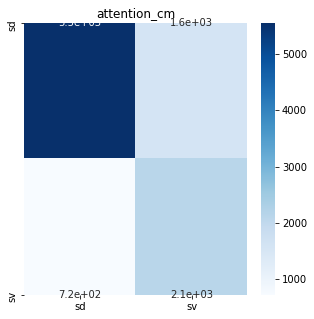

In [73]:
attention_cm = confusion_matrix(y_test, y_pred, non_remove_labels)
df = pd.DataFrame(attention_cm, index=non_remove_labels, columns=non_remove_labels)
plt.figure(figsize=(5, 5))
plt.title("attention_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("./graph/attention_cm3.png")

In [74]:
print(attention_cm)

[[5549 1579]
 [ 723 2133]]


## self-attention(双方向)

In [87]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, BATCH_SIZE)(inp) # (?,128,32)
gru_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(BATCH_SIZE,return_sequences=True))(emb_output)
att_layer_output = SeqSelfAttention(name='attention')(gru_output)  # embbedingレイヤーの後にselfattentionを配置
out = tf.keras.layers.GlobalMaxPooling1D()(att_layer_output) # outputのshapeの次元数を落とす(3次元->2次元)
output = tf.keras.layers.Dense(2, activation='softmax')(out)  # shape=(?, 41)
self_attention_model_max = tf.keras.Model(inp, output)
self_attention_model_max.summary()
self_attention_model_max.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (64, None, 64)            1427328   
_________________________________________________________________
bidirectional_2 (Bidirection (64, None, 128)           49920     
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 128)           8257      
_________________________________________________________________
global_max_pooling1d_4 (Glob (64, 128)                 0         
_________________________________________________________________
dense_14 (Dense)             (64, 2)                   258       
Total params: 1,485,763
Trainable params: 1,485,763
Non-trainable params: 0
____________________________________________

### モデルの実行

In [88]:
self_attention_history_max = self_attention_model_max.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
1274/1274 [==============================] - 50s 39ms/step - loss: 0.4266 - tp: 66661.0000 - fp: 16795.0000 - tn: 66661.0000 - fn: 16795.0000 - accuracy: 0.7988 - precision: 0.7988 - recall: 0.7988 - auc: 0.8819 - val_loss: 0.3510 - val_tp: 1604.0000 - val_fp: 316.0000 - val_tn: 1604.0000 - val_fn: 316.0000 - val_accuracy: 0.8354 - val_precision: 0.8354 - val_recall: 0.8354 - val_auc: 0.9222
Epoch 2/14
1274/1274 [==============================] - 49s 39ms/step - loss: 0.3596 - tp: 67912.0000 - fp: 13624.0000 - tn: 67912.0000 - fn: 13624.0000 - accuracy: 0.8329 - precision: 0.8329 - recall: 0.8329 - auc: 0.9190 - val_loss: 0.3663 - val_tp: 1594.0000 - val_fp: 326.0000 - val_tn: 1594.0000 - val_fn: 326.0000 - val_accuracy: 0.8302 - val_precision: 0.8302 - val_recall: 0.8302 - val_auc: 0.9168
Epoch 3/14
1274/1274 [==============================] - 49s 39ms/step - loss: 0.3258 - tp: 69449.0000 - fp: 12087.0000 - tn: 69449.0000 - fn: 12087.0000 - accuracy: 0.8518 - precision: 0.8

### モデルの評価

In [89]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_model_max.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
        y_test.append(non_remove_labels[i])
    for i in pred:
        y_pred.append(non_remove_labels[i])

print(len(y_test))

9984


#### accuracy & macro平均F値

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          sd       0.88      0.79      0.83      7128
          sv       0.58      0.73      0.65      2856

    accuracy                           0.77      9984
   macro avg       0.73      0.76      0.74      9984
weighted avg       0.80      0.77      0.78      9984



#### 混同行列

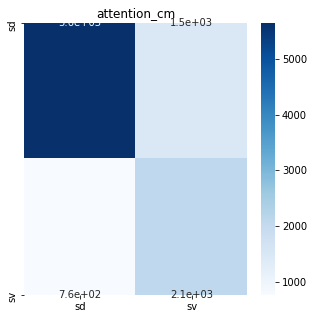

In [91]:
attention_cm = confusion_matrix(y_test, y_pred, non_remove_labels)
df = pd.DataFrame(attention_cm, index=non_remove_labels, columns=non_remove_labels)
plt.figure(figsize=(5, 5))
plt.title("attention_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("./graph/attention_cm3.png")

In [92]:
print(attention_cm)

[[5642 1486]
 [ 765 2091]]


## データ状況